# Model definition

In [1]:
"""PointNet
Reference:
https://github.com/yanx27/Pointnet_Pointnet2_pytorch/blob/master/models/pointnet_utils.py

"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class STN3d(nn.Module):
    def __init__(self, channel=3):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.iden = torch.from_numpy(np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)).reshape(1, 9)

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = self.iden.repeat(batchsize, 1).to(x.device)
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k
        self.iden = torch.from_numpy(np.eye(self.k).flatten().astype(np.float32)).reshape(1, self.k * self.k)

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = self.iden.repeat(batchsize, 1).to(x.device)

        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x


class PointNetEncoder(nn.Module):
    """Encoder for PointNet

    Args:
        nn (_type_): _description_
    """

    def __init__(self,
                 in_channels: int,
                 input_transform: bool=True,
                 feature_transform: bool=True,
                 is_seg: bool=False,  
                 **kwargs
                 ):
        """_summary_

        Args:
            in_channels (int): feature size of input 
            input_transform (bool, optional): whether to use transformation for coordinates. Defaults to True.
            feature_transform (bool, optional): whether to use transformation for features. Defaults to True.
            is_seg (bool, optional): for segmentation or classification. Defaults to False.
        """
        super().__init__()
        self.stn = STN3d(in_channels) if input_transform else None
        self.conv0_1 = torch.nn.Conv1d(in_channels, 64, 1)
        self.conv0_2 = torch.nn.Conv1d(64, 64, 1)

        self.conv1 = torch.nn.Conv1d(64, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn0_1 = nn.BatchNorm1d(64)
        self.bn0_2 = nn.BatchNorm1d(64)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fstn = STNkd(k=64) if feature_transform else None
        self.out_channels = 1024 + 64 if is_seg else 1024 
         
    def forward_cls_feat(self, pos, x=None):
        if hasattr(pos, 'keys'):
            x = pos['x']
        if x is None:
            x = pos.transpose(1, 2).contiguous()
        
        B, D, N = x.size()
        if self.stn is not None:
            trans = self.stn(x)
            x = x.transpose(2, 1)
            if D > 3:
                feature = x[:, :, 3:]
                x = x[:, :, :3]
            x = torch.bmm(x, trans)
            if D > 3:
                x = torch.cat([x, feature], dim=2)
            x = x.transpose(2, 1)
        x = F.relu(self.bn0_1(self.conv0_1(x)))
        x = F.relu(self.bn0_2(self.conv0_2(x)))

        if self.fstn is not None:
            trans_feat = self.fstn(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        else:
            trans_feat = None
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        return x

    def forward_seg_feat(self, pos, x=None):
        if hasattr(pos, 'keys'):
            x = pos.get('x', None)
        if x is None:
            x = pos.transpose(1, 2).contiguous()

        B, D, N = x.size()
        if self.stn is not None:
            trans = self.stn(x)
            x = x.transpose(2, 1)
            if D > 3:
                feature = x[:, :, 3:]
                x = x[:, :, :3]
            x = torch.bmm(x, trans)
            if D > 3:
                x = torch.cat([x, feature], dim=2)
            x = x.transpose(2, 1)
        x = F.relu(self.bn0_1(self.conv0_1(x)))
        x = F.relu(self.bn0_2(self.conv0_2(x)))

        if self.fstn is not None:
            trans_feat = self.fstn(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024, 1).repeat(1, 1, N)
        return pos, torch.cat([pointfeat, x], 1)
    
    def forward(self, x, features=None):
        return self.forward_cls_features(x)

In [2]:
class PointNetWithHead(nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier
        
    def forward(self, x):
        # Pass x as B,C,N and avoid automatic transpose
        features = self.encoder.forward_cls_feat(x, x=x)
        out = self.classifier(features)
        return out



# Dataset class definition

In [3]:
import json
import torch
from torch.utils.data import Dataset
import numpy as np

class ConeClusterDataset(Dataset):
    def __init__(self, json_files, num_points=128):
        """
        json_files: list of paths to your JSON cluster files
        num_points: fixed number of points per cluster
        """
        self.samples = []
        self.num_points = num_points

        for file_path in json_files:
            with open(file_path, 'r') as f:
                data = json.load(f)
            for frame in data.values():
                for cluster in frame['clusters']:
                    points = cluster['points']
                    label = cluster['label']
                    if label == 255:
                        label=0
                    self.samples.append((points, label))

        

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        points, label = self.samples[idx]

        # Convert to numpy array (N, 4) [x, y, z, intensity]
        pts = np.array([[p['x'], p['y'], p['z'], p['i']] for p in points], dtype=np.float32)
        
        # Normalize coordinates relative to centroid
        centroid = pts[:, :3].mean(axis=0, keepdims=True)  # (1,3)
        pts[:, :3] -= centroid

        # Normalize intensity
        pts[:, 3] /= 255.0

        # Downsample or pad
        N = pts.shape[0]
        if N >= self.num_points:
            choice = np.random.choice(N, self.num_points, replace=False)
            pts = pts[choice]
        else:
            pad = np.zeros((self.num_points - N, pts.shape[1]), dtype=np.float32)
            pts = np.vstack([pts, pad])

        return torch.tensor(pts, dtype=torch.float32), torch.tensor(label, dtype=torch.long)



# Evaluation

In [4]:
json_files = ["../data/fsg_accel_2024_08_16-11_06_03_recovered_filtered_0_labels.json", "../data/skidpad_2025-08-06-17_26_12_merged_filtered_0_labels.json"]

## Load the models
The model with the lowest validation loss was chosen over all 3 training runs was chosen.

In [5]:
from torch import nn

In [6]:
INPUT_SIZE = 1024
NUM_CLASSES = 4

In [7]:
best_model_sweep= "/home/laurens/Pointcloud-Object-Classification/models/pointnet_best.pth"

In [8]:
encoder = PointNetEncoder(in_channels=4)

In [9]:
fc_hidden_size = 256
dropout = 0.2265648793873729
num_fc_layers = 2
num_points = 128

fc = nn.Sequential(
    nn.Linear(INPUT_SIZE, fc_hidden_size),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(fc_hidden_size, NUM_CLASSES)
)

model = PointNetWithHead(encoder, fc)
model.load_state_dict(torch.load(best_model_sweep))

<All keys matched successfully>

## Load the test data

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

batch_size = 16

dataset = ConeClusterDataset(json_files, num_points=num_points)
labels = np.array([dataset[i][1].item() for i in range(len(dataset))])

train_idx, temp_idx = train_test_split(np.arange(len(labels)), test_size=0.2, stratify=labels, random_state=599) 
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=labels[temp_idx], random_state=599)

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

## Evaluation

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

PointNetWithHead(
  (encoder): PointNetEncoder(
    (stn): STN3d(
      (conv1): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv0_1): Conv1d(4, 64, kernel_size=(1,), stride=

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_preds = []
all_labels = []

for data, labels in test_loader:
    # Move to device
    data, labels = data.to(device), labels.to(device)

    # Permute to (batch_size, channels=4, num_points)
    data = data.permute(0, 2, 1)

    # Forward pass
    outputs = model(data)

    _, predicted = torch.max(outputs, 1)
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Get score per class
precision_per_class = precision_score(all_labels, all_preds, average=None)
recall_per_class = recall_score(all_labels, all_preds, average=None)
f1_per_class = f1_score(all_labels, all_preds, average=None)

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)
print("F1 per class:", f1_per_class)


Precision per class: [0.96610169 0.87179487 0.64814815 0.4       ]
Recall per class: [0.94214876 0.91891892 0.92105263 0.1       ]
F1 per class: [0.9539749  0.89473684 0.76086957 0.16      ]


In [17]:
all_preds_no_classes = []
all_labels_no_classes = []

for pred, label in zip(all_preds, all_labels):
    if pred != 0:
        all_preds_no_classes.append(1)
    else:
        all_preds_no_classes.append(0)

    if label != 0:
        all_labels_no_classes.append(1)
    else:
        all_labels_no_classes.append(0)

precision_no_types = precision_score(all_labels_no_classes, all_preds_no_classes, average=None)
recall_no_types = recall_score(all_labels_no_classes, all_preds_no_classes, average=None)
f1_no_types = f1_score(all_labels_no_classes, all_preds_no_classes, average=None)


In [18]:
print(precision_no_types)
print(recall_no_types)
print(f1_no_types)

[0.96610169 0.92857143]
[0.94214876 0.95789474]
[0.9539749  0.94300518]


In [13]:
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

In [14]:
print(f"Total precision: {precision}")
print(f"Total recall: {recall}")
print(f"Total f1-score: {f1}")

Total precision: 0.8415941896795631
Total recall: 0.8564814814814815
Total f1-score: 0.836339208237277


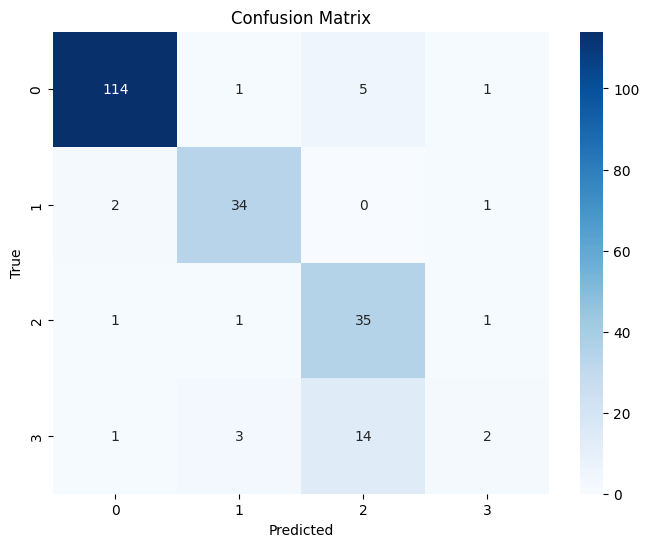

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# all_labels and all_preds should be lists or arrays of ints
# e.g., collected from your test_loader loop
cm = confusion_matrix(all_labels, all_preds)

# Optional: plot nicely
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Conclusions
Based on the results, the model demonstrates strong overall performance, particularly in distinguishing actual cones from false positives, as evidenced by the high precision and recall for class 0. Yellow cones (class 1) are also classified with high accuracy, while the model shows moderate performance on blue (class 2) and orange cones (class 3), likely due to class imbalance or visual similarity. The confusion matrix highlights that most misclassifications occur between blue and orange cones rather than with false positives, confirming that the model reliably filters out non-cone objects. Overall, the high F1-scores and low confusion with FP indicate the model is effective for practical cone detection, though further improvements could focus on better differentiating blue and orange cones.